## Uber Supply-Demand Case Study

### Business Objective:  
The aim of analysis is to identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to improve the situation. As a result of your analysis, you should be able to present to the client the root cause(s) and possible hypotheses of the problem(s) and recommend ways to improve them.  



In [1]:
# Importing the required libraries:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import chardet

In [2]:
# reading the data-set :
uber_df = pd.read_csv("Uber Request Data.csv")
uber_df.head()

,Request id,Pick-up point,Driver id,Status of the request,Time of request,Drop-off time
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


#### Checking the dimension of the dataset :

In [78]:
# checking the basic information of data set :
uber_df.shape

(6745, 6)

In [79]:
# Dataset is having 6745 rows and 6 columns

In [80]:
# Data-types and NULLs:
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


In [81]:
# There are two numerical attributes and rest are non-numrerical types

#### checking the % of NAs columnwise

In [82]:
# Finding the null percentage of the data set for all columns:
# Find the percentage of missing values for all the columns:

print(round(100*(uber_df.isnull().sum(axis=0)/len(uber_df.index)),2))

Request id            0.00
Pickup point          0.00
Driver id            39.29
Status                0.00
Request timestamp     0.00
Drop timestamp       58.03
dtype: float64


In [83]:
# There are 39.29 % of missing values for the driver id and 58% of missing values for the Drop timestamp.
# We are not much concerned about the missing values of the Drop timestamp as it might be for the cancelled trip.

In [84]:
# Finding the datatypes of the columns:
print(uber_df.dtypes)

Request id             int64
Pickup point          object
Driver id            float64
Status                object
Request timestamp     object
Drop timestamp        object
dtype: object


#### check for NA values in each columns except "Driver id" and "Drop timestamp" (Cross Verification)

In [85]:
print(uber_df["Request id"].isnull().values.any())
print(uber_df["Pickup point"].isnull().values.any())
print(uber_df["Status"].isnull().values.any())
print(uber_df["Request timestamp"].isnull().values.any())

False
False
False
False


In [86]:
print(uber_df["Request id"].isnull().values.sum())
print(uber_df["Pickup point"].isnull().values.sum())
print(uber_df["Status"].isnull().values.sum())
print(uber_df["Request timestamp"].isnull().values.sum())

0
0
0
0


#### Correcting the data-types of the date type features :

In [87]:
uber_df["Request timestamp"] = uber_df["Request timestamp"].astype(str)
uber_df["Request timestamp"] = uber_df["Request timestamp"].str.replace("/","-")
uber_df["Request timestamp"] = pd.to_datetime(uber_df["Request timestamp"],dayfirst=True)

In [88]:
uber_df["Drop timestamp"] = uber_df["Drop timestamp"].astype(str)
uber_df["Drop timestamp"] = uber_df["Drop timestamp"].str.replace("/","-")
uber_df["Drop timestamp"] = pd.to_datetime(uber_df["Drop timestamp"],dayfirst=True)

In [89]:
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Request id         6745 non-null   int64         
 1   Pickup point       6745 non-null   object        
 2   Driver id          4095 non-null   float64       
 3   Status             6745 non-null   object        
 4   Request timestamp  6745 non-null   datetime64[ns]
 5   Drop timestamp     2831 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 316.3+ KB


#### Creating the derived feature for time data:

In [90]:
# extract the hour from the request time:
req_hr = uber_df["Request timestamp"].dt.hour
req_hr.head()
req_hr.value_counts()
uber_df["req_hr"]=req_hr 

In [91]:
# extract the day from the request time:
req_day = uber_df["Request timestamp"].dt.day
req_day.head()
req_day.value_counts()
uber_df["req_day"]=req_day 

C:\Users\Ashutosh\Anaconda3\envs\tensorenviron\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


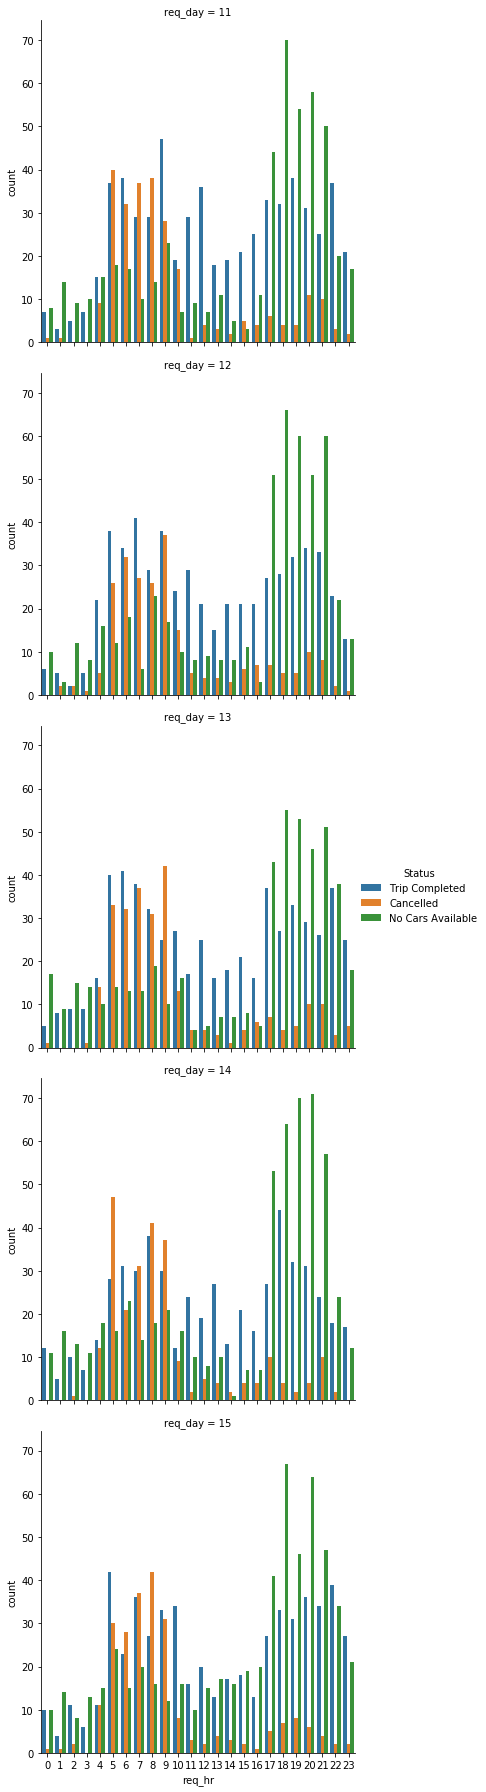

In [92]:
# factor plot of hour and day w.r.t. status:
sns.factorplot(x = "req_hr", hue = "Status", row = "req_day", data = uber_df, kind = "count")

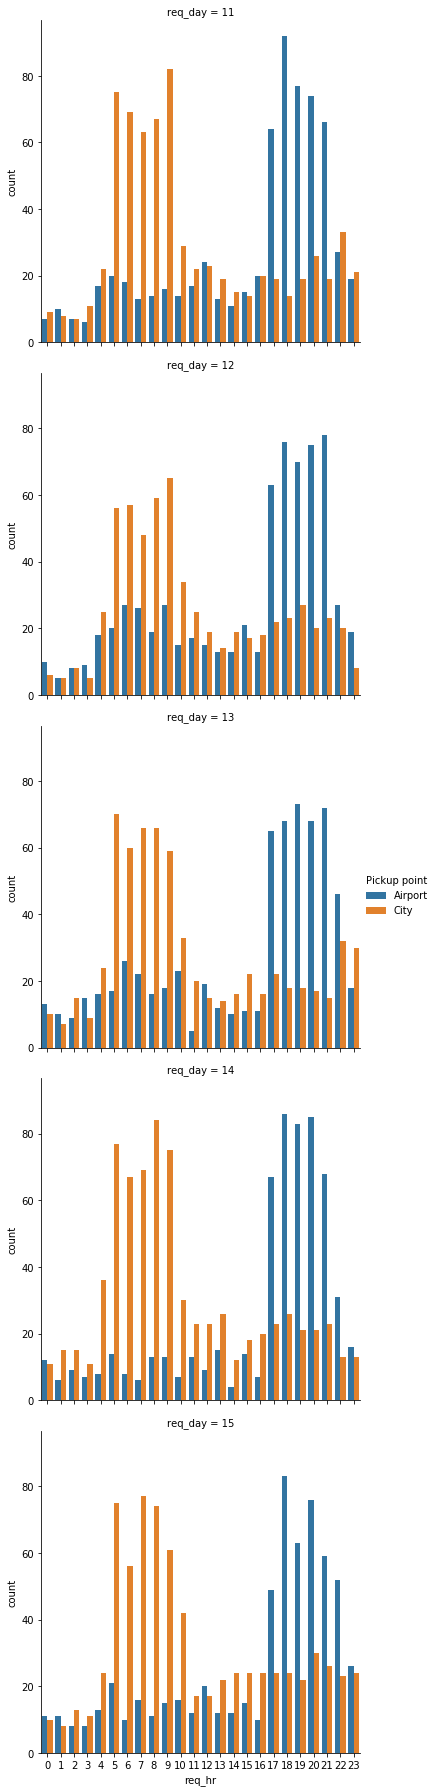

In [93]:
# factor plot of hour and day w.r.t. pickup point
sns.factorplot(x = "req_hr", hue = "Pickup point", row = "req_day", data = uber_df, kind = "count")

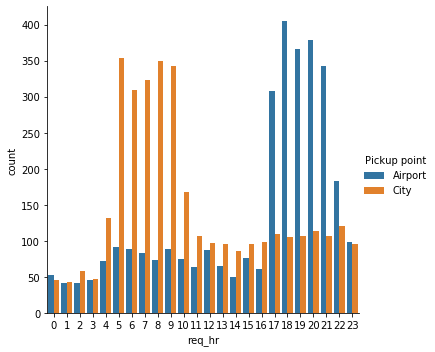

In [94]:
# aggregate count plot for all days w.r.t. to Pickup point
sns.factorplot(x = "req_hr", hue = "Pickup point", data = uber_df, kind = "count")

#### Creating a timeslot derived variable for time of the day:

In [95]:
# creating a time slot for various time period of day:

def time_slot(x):
    'divide the time of the day into four categories'
    if x <=5:
        return("Early_Morning")
    elif 5 <x <=10:
        return("Morning_Rush")
    elif 10 <x <=17:
        return("Day_Time")
    elif 17 <x <=22:
        return("Evening_Rush")
    else:
        return("Late_Night")
    
    
uber_df["Time_slot_book"] = uber_df.req_hr.apply(lambda x: time_slot(x) )      

In [96]:
uber_df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,req_hr,req_day,Time_slot_book
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,11,11,Day_Time
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,17,11,Day_Time
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,9,12,Morning_Rush
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,21,12,Evening_Rush
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,13,Morning_Rush


In [97]:
uber_df.Time_slot_book.value_counts()

Evening_Rush     2228
Morning_Rush     1901
Day_Time         1399
Early_Morning    1023
Late_Night        194
Name: Time_slot_book, dtype: int64

In [98]:
# Most of the rides are booked in the evening rush time according to above data 

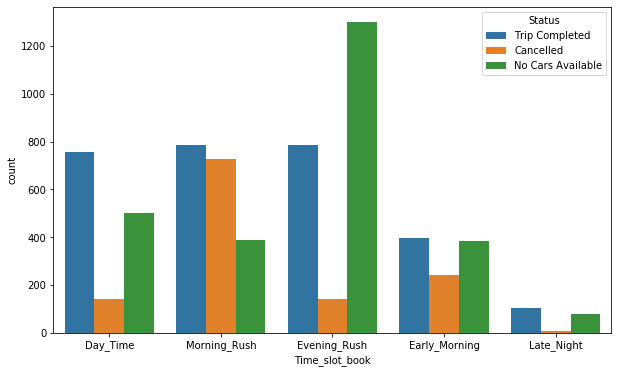

In [99]:
plt.figure(figsize=(10,6))
sns.countplot(x="Time_slot_book" ,data=uber_df, hue="Status" )
plt.show()

In [100]:
# as we can see in the above plot the higest number of cancellations are in the "Morning Rush" time slot

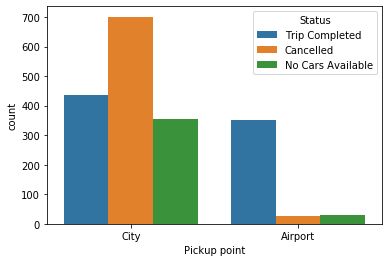

In [101]:
# Let's dig deeper into the problem with the morning rush time slot :

df_morning_rush = uber_df[uber_df.Time_slot_book == "Morning_Rush"]
sns.countplot(x = "Pickup point", hue = "Status", data = df_morning_rush)

In [102]:
df_airport_cancelled = df_morning_rush.loc[(df_morning_rush["Pickup point"]=="Airport") & (df_morning_rush["Status"]=="Cancelled")]
len(df_airport_cancelled)

28

In [103]:
df_city_cancelled = df_morning_rush.loc[(df_morning_rush["Pickup point"]=="City") & (df_morning_rush["Status"]=="Cancelled")]
len(df_city_cancelled)

701

In [104]:
# let's look at the supply and demand in morning rush hour in the city
df_city_completed_morning_rush = df_morning_rush.loc[(df_morning_rush["Pickup point"] == "City") & (df_morning_rush["Status"] == "Trip Completed")]
len(df_city_completed_morning_rush.index)

435

In [105]:
df_city_morning_rush  = df_morning_rush.loc[(df_morning_rush["Pickup point"] == "City")]
len(df_city_morning_rush.index)

1492

In [106]:
# let's look at the supply and demand in morning rush hour at the airport
df_airport_completed_morning_rush = df_morning_rush.loc[(df_morning_rush["Pickup point"] == "Airport") & (df_morning_rush["Status"] == "Trip Completed")]
len(df_airport_completed_morning_rush.index)

350

In [107]:
df_airport_morning_rush  = df_morning_rush.loc[(df_morning_rush["Pickup point"] == "Airport")]
len(df_airport_morning_rush.index)

409

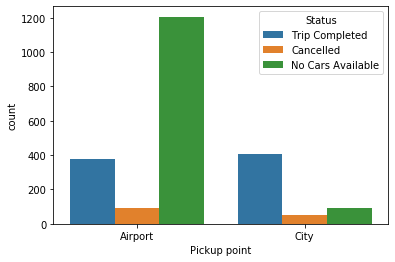

In [108]:
# let's look at the supply and demand in evening rush hour:
df_evening_rush = uber_df[uber_df.Time_slot_book == "Evening_Rush"]
sns.countplot(x = "Pickup point", hue = "Status", data = df_evening_rush)

In [109]:
# let's look at the supply and demand in evening rush hour in the city
df_city_completed_evening_rush = df_evening_rush.loc[(df_evening_rush["Pickup point"] == "City") & (df_evening_rush["Status"] == "Trip Completed")]
len(df_city_completed_evening_rush.index)

408

In [110]:
df_city_evening_rush  = df_evening_rush.loc[(df_evening_rush["Pickup point"] == "City")]
len(df_city_evening_rush.index)

553

In [111]:
# let's look at the supply and demand in evening rush hour from the airport
df_airport_completed_evening_rush = df_evening_rush.loc[(df_evening_rush["Pickup point"] == "Airport") & (df_evening_rush["Status"] == "Trip Completed")]
len(df_airport_completed_evening_rush.index)

379

In [112]:
df_airport_evening_rush  = df_evening_rush.loc[(df_evening_rush["Pickup point"] == "Airport")]
len(df_airport_evening_rush.index)

1675

In [113]:
# let's look at the severity problem (of demand and supply) at each location by looking at cancellation of cab in each of the pickup location in evening rush
df_airport_cancelled_evening_rush  = df_evening_rush.loc[(df_evening_rush["Pickup point"] == "Airport") & (df_evening_rush["Status"] == "Cancelled")]
len(df_airport_cancelled_evening_rush.index)

90

In [114]:
df_city_cancelled_evening_rush = df_evening_rush.loc[(df_evening_rush["Pickup point"] == "City") & (df_evening_rush["Status"] == "Cancelled")]
len(df_city_cancelled_evening_rush.index)

53

In [115]:
# severity of problem by location in Morning Rush (Unavailability of Cars)
df_airport_unavailable_morning_rush  = df_morning_rush.loc[(df_morning_rush["Pickup point"] == "Airport") & (df_morning_rush["Status"] == "No Cars Available")]
len(df_airport_unavailable_morning_rush.index)

31

In [116]:
df_city_unavailable_morning_rush  = df_morning_rush.loc[(df_morning_rush["Pickup point"] == "City") & (df_morning_rush["Status"] == "No Cars Available")]
len(df_city_unavailable_morning_rush.index)

356

In [117]:
# severity of problem by location in Evening Rush (Unavailability of Cars)
df_airport_unavailable_evening_rush  = df_evening_rush.loc[(df_evening_rush["Pickup point"] == "Airport") & (df_evening_rush["Status"] == "No Cars Available")]
len(df_airport_unavailable_evening_rush.index)

1206

In [118]:
df_city_unavailable_evening_rush  = df_evening_rush.loc[(df_evening_rush["Pickup point"] == "City") & (df_evening_rush["Status"] == "No Cars Available")]
len(df_city_unavailable_evening_rush.index)

92

In [119]:
# Let's create pie charts instead of a count plots
def pie_chart(dataframe):
    """
    creates a pie chart
    input: dataframe with a 'category' as index and a numerical column
    output: pie chart
    """
    labels = dataframe.index.values
    sizes = dataframe['Status'].values
        
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

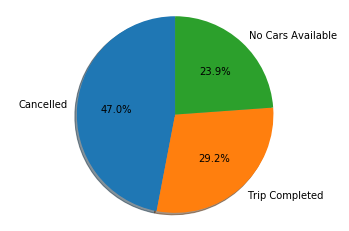

In [120]:
# percentage breakup of status on the basis of pickup location
# Status of trips @ Morning Rush where pickup point is City:

df_city = uber_df.loc[(uber_df["Pickup point"] == "City") & (uber_df.Time_slot_book == "Morning_Rush")]
df_city_count = pd.DataFrame(df_city.Status.value_counts())
pie_chart(df_city_count)

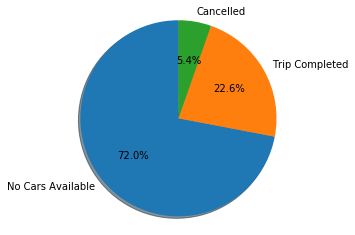

In [121]:
# Status of trips @ Evening Rush where pickup point is Airport:

df_airport = uber_df.loc[(uber_df["Pickup point"] == "Airport") & (uber_df.Time_slot_book == "Evening_Rush")] 
df_airport_count = pd.DataFrame(df_airport.Status.value_counts())
pie_chart(df_airport_count)

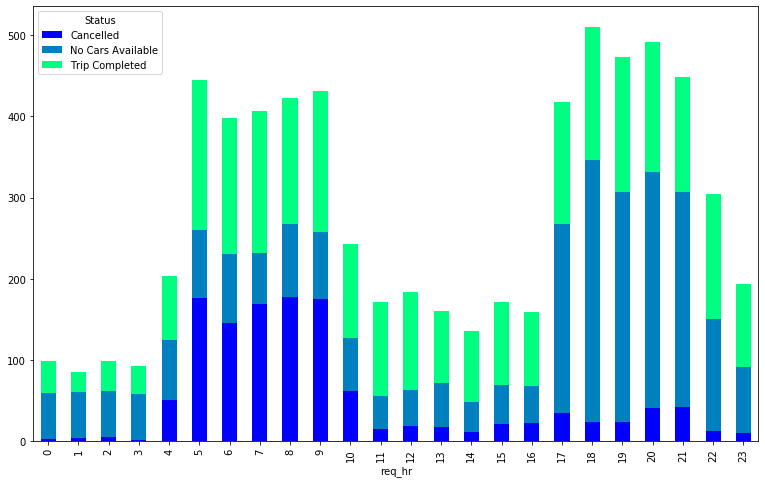

In [122]:
df_plot = uber_df.groupby(['Status', 'req_hr']).size().reset_index().pivot(columns='Status', index='req_hr', values=0)
df_plot.plot(kind='bar', stacked=True, colormap='winter',figsize=(13,8), legend=True)

In [123]:
# Conclusion: 
# Graph clearly shows that the major problems are:
# 1. Cancelled trips during the morning rush
# 2. Unavailability of cars during evening rush

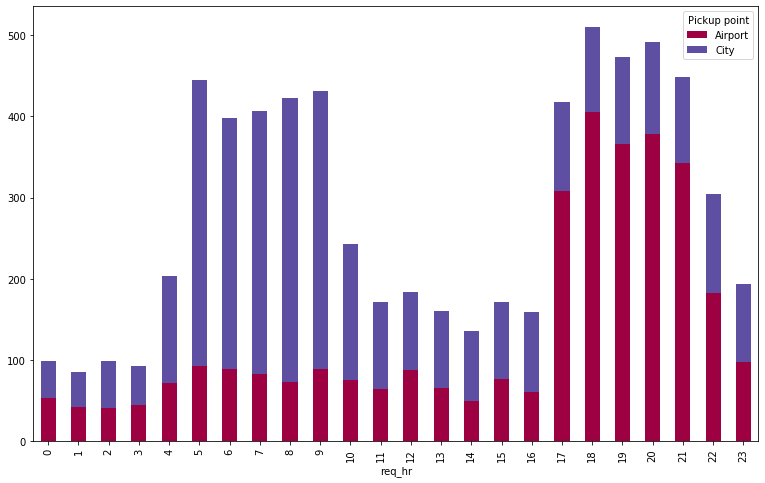

In [124]:
df_plot_new = uber_df.groupby(['Pickup point', 'req_hr']).size().reset_index().pivot(columns='Pickup point', index='req_hr', values=0)
df_plot_new.plot(kind='bar', stacked=True, colormap='Spectral',figsize=(13,8), legend=True)

In [125]:
## Conclusion:  
# 1. Number of trips in morning are high from the city  
# 2. Number of trips from the evening are high from the airport

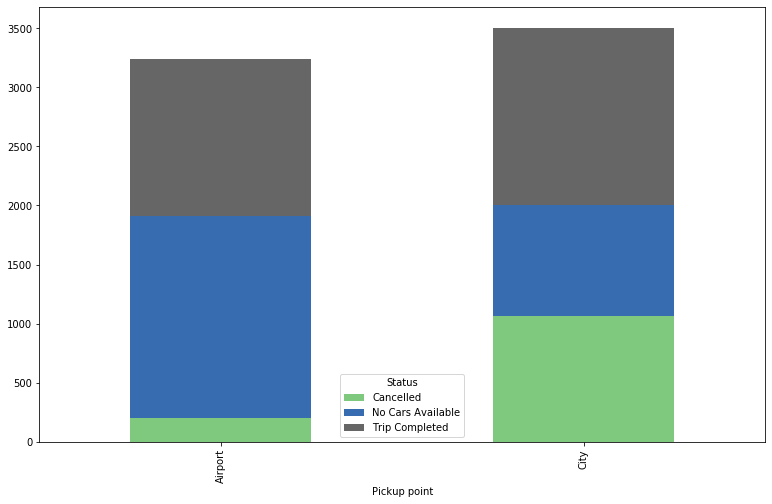

In [126]:
df_plot_new = uber_df.groupby(['Pickup point','Status']).size().reset_index().pivot(columns='Status', index='Pickup point', values=0)
df_plot_new.plot(kind='bar', stacked=True, colormap='Accent',figsize=(13,8), legend=True)

In [128]:
# Cancelled trips - 50 % of total trips from city
# No Cars - 70 % of total trips from airport

# Huge difference between the supply and demand 

### Recommendations :

**• For the trips in the morning, drivers can be incentivised to make those trips.**
1. They could be given a bonus for each trip they complete from the city to the airport in the morning
rush. This will ensure that less number of trips are cancelled.
2. Uber can pay for the gas mileage of drivers to come back to the city without a ride.
3. Uber can increase the demand at the airport to reduce idle time – by increased marketing and price
cuts for the passengers  
  
**• For the evening, since the number of drivers is less, some of the ways are:**
1. Drivers can again be given a bonus to complete a trip from the airport in the evening. This will ensure
that the supply increases at the airport.
2. Uber can also pay drivers to come without a passenger to the airport
3. Another innovative way can be to pool the rides of passengers so that lesser number of cars can
serve more passengers.

In [50]:
################################################## End of Case Study #####################################################